In [1]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join('..', 'src')))

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale
from sklearn.metrics.pairwise import cosine_similarity
from datasets import load_dataset
from scipy import stats
from sentence_transformers import SentenceTransformer

from sif import compute_word_frequencies, compute_sif_weights, compute_sif_embeddings, remove_pc_sif
from similarity import calculate_similarity
from glove import load_glove_vectors
from prepare_data import preprocess_text

/Users/yegor/Desktop/学校/S24/CompLing/SIF_minmax/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to /Users/yegor/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/yegor/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
ds = load_dataset("mteb/stsbenchmark-sts")
glove_vectors = load_glove_vectors("../data/raw/glove.6B.300d.txt")

In [3]:
df_sts = ds["train"].data.to_pandas()
df_sts['sentence1'] = preprocess_text(df_sts['sentence1'])
df_sts['sentence2'] = preprocess_text(df_sts['sentence2'])
sentences = df_sts[['sentence1', 'sentence2']].values.flatten().tolist()

In [4]:
word_freq = compute_word_frequencies(sentences)
sif_weights = compute_sif_weights(word_freq)

In [ ]:
corpus = [df_sts['sentence1'].tolist(), df_sts['sentence2'].tolist()]
embeddings1 = compute_sif_embeddings(corpus[0], glove_vectors, sif_weights)
embeddings2 = compute_sif_embeddings(corpus[1], glove_vectors, sif_weights)

In [7]:
embeddings1_pc_removed = remove_pc_sif(embeddings1)
embeddings2_pc_removed = remove_pc_sif(embeddings2)

In [8]:
similarities = calculate_similarity(embeddings1_pc_removed, embeddings2_pc_removed)
scaled_similarities = minmax_scale(similarities)

df_sts['minmax_similarity'] = scaled_similarities

In [9]:
df_sts['sentence1'] = df_sts['sentence1'].apply(' '.join)
df_sts['sentence2'] = df_sts['sentence2'].apply(' '.join)

In [10]:
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings1 = model.encode(df_sts['sentence1'].tolist())
embeddings2 = model.encode(df_sts['sentence2'].tolist())

sbert_similarities = [cosine_similarity(embeddings1[i].reshape(1, -1), 
                                        embeddings2[i].reshape(1, -1))[0][0] 
                      for i in range(len(df_sts))]

sbert_correlation = np.corrcoef(df_sts['score'], sbert_similarities)[0, 1]
print(f'SentenceTransformer Correlation: {sbert_correlation}')

SentenceTransformer Correlation: 0.8169475668582626


In [11]:
df_sts['sbert_similarity'] = sbert_similarities

sbert_pearson_corr = np.corrcoef(df_sts['score'], df_sts['sbert_similarity'])[0, 1]
sbert_spearman_corr, _ = stats.spearmanr(df_sts['score'], df_sts['sbert_similarity'])

sif_pearson_corr = np.corrcoef(df_sts['score'], df_sts['minmax_similarity'])[0, 1]
sif_spearman_corr, _ = stats.spearmanr(df_sts['score'], df_sts['minmax_similarity'])

print(f'SentenceTransformer Pearson Correlation: {sbert_pearson_corr}')
print(f'SentenceTransformer Spearman Correlation: {sbert_spearman_corr}')
print(f'SIF Pearson Correlation: {sif_pearson_corr}')
print(f'SIF Spearman Correlation: {sif_spearman_corr}')

SentenceTransformer Pearson Correlation: 0.8169475668582626
SentenceTransformer Spearman Correlation: 0.7852622328191703
SIF Pearson Correlation: 0.5648092841007839
SIF Spearman Correlation: 0.5492536528287979


In [12]:
df_sts

,split,genre,dataset,year,sid,score,sentence1,sentence2,minmax_similarity,sbert_similarity
0,train,main-captions,MSRvid,2012test,0001,5.00,plane taking,air plane taking,0.956410,0.914385
1,train,main-captions,MSRvid,2012test,0004,3.80,man playing large flute,man playing flute,0.938606,0.891910
2,train,main-captions,MSRvid,2012test,0005,3.80,man spreading shreded cheese pizza,man spreading shredded cheese uncooked pizza,0.594706,0.864864
3,train,main-captions,MSRvid,2012test,0006,2.60,three men playing chess,two men playing chess,0.999975,0.759767
4,train,main-captions,MSRvid,2012test,0009,4.25,man playing cello,man seated playing cello,0.966322,0.914014
...,...,...,...,...,...,...,...,...,...,...
5744,train,main-news,headlines,2016,1456,0.00,severe gales storm clodagh hits britain,merkel pledges nato solidarity latvia,0.167924,0.046905
5745,train,main-news,headlines,2016,1465,0.00,dozens egyptians hostages taken libyan terrori...,egyptian boat crash death toll rises bodies fo...,0.355758,0.323372
5746,train,main-news,headlines,2016,1466,0.00,president heading bahrain,president xi china continue help fight ebola,0.254602,0.060961
5747,train,main-news,headlines,2016,1470,0.00,china india vow bilateral ties,china scrambles reassure jittery stock traders,0.326875,0.299494


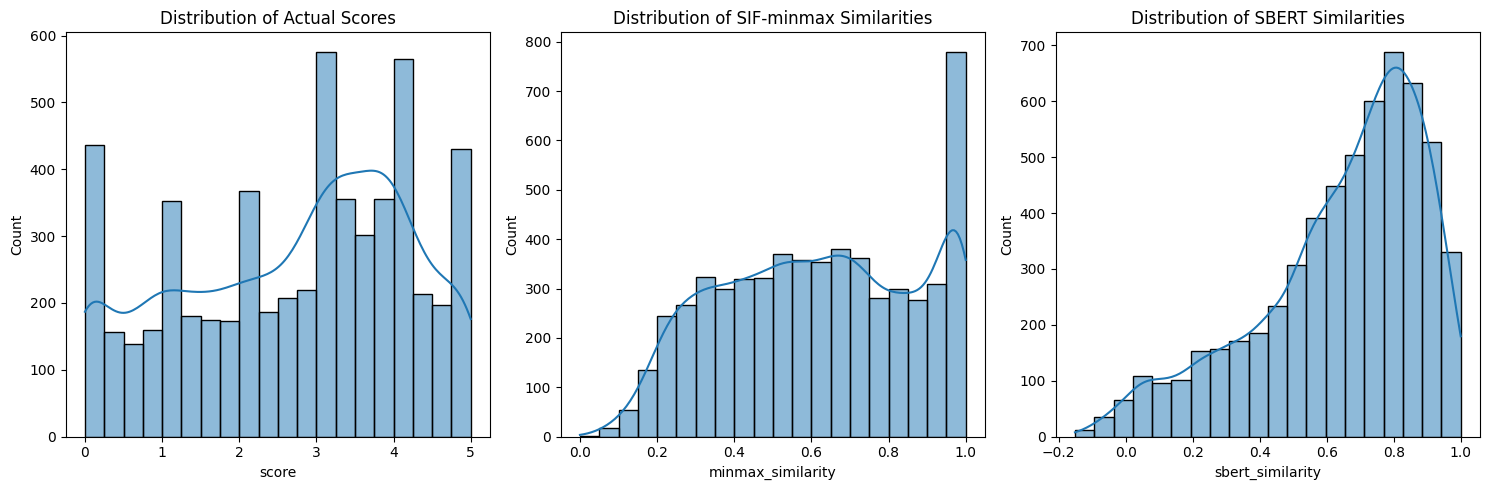

In [13]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(df_sts['score'], bins=20, kde=True)
plt.title('Distribution of Actual Scores')

plt.subplot(1, 3, 2)
sns.histplot(df_sts['minmax_similarity'], bins=20, kde=True)
plt.title('Distribution of SIF-minmax Similarities')

plt.subplot(1, 3, 3)
sns.histplot(df_sts['sbert_similarity'], bins=20, kde=True)
plt.title('Distribution of SBERT Similarities')

plt.tight_layout()
plt.show()


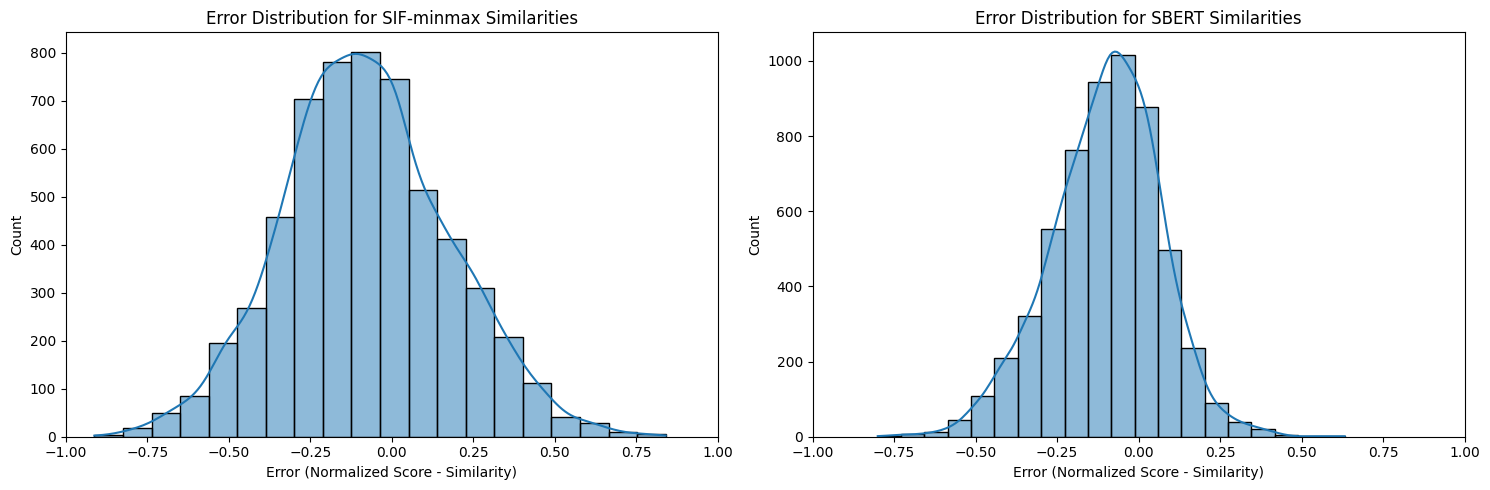

In [14]:

def analyze_errors(df_sts):
    df_sts['score_normalized'] = df_sts['score'] / 5
    df_sts['error_minmax'] = df_sts['score_normalized'] - df_sts['minmax_similarity']
    df_sts['error_sbert'] = df_sts['score_normalized'] - df_sts['sbert_similarity']

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    sns.histplot(df_sts['error_minmax'], bins=20, kde=True)
    plt.title('Error Distribution for SIF-minmax Similarities')
    plt.xlabel('Error (Normalized Score - Similarity)')
    plt.xlim(-1, 1) 

    plt.subplot(1, 2, 2)
    sns.histplot(df_sts['error_sbert'], bins=20, kde=True)
    plt.title('Error Distribution for SBERT Similarities')
    plt.xlabel('Error (Normalized Score - Similarity)')
    plt.xlim(-1, 1) 

    plt.tight_layout()
    plt.show()

analyze_errors(df_sts)

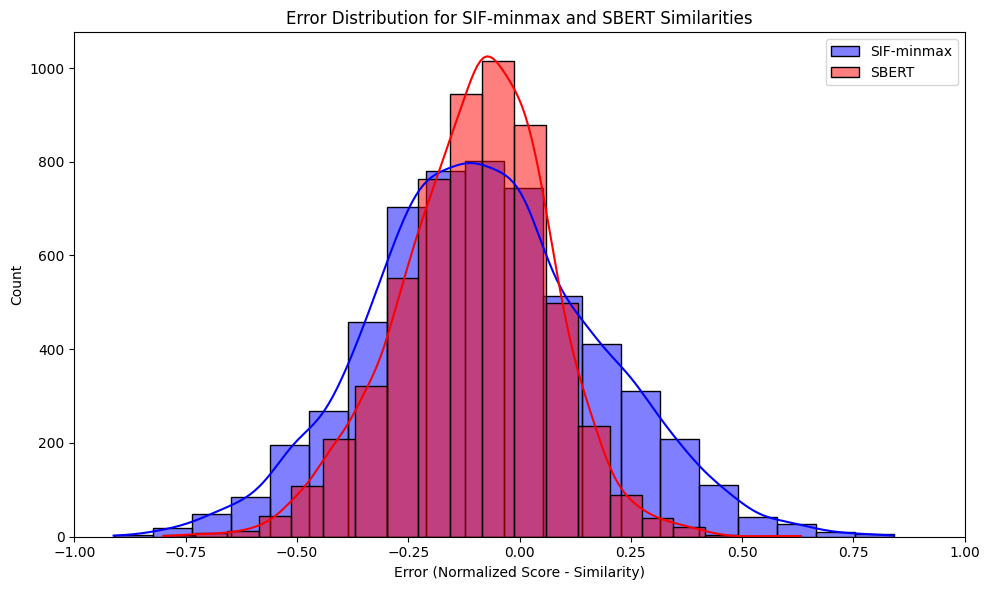

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_errors(df_sts):
    df_sts['score_normalized'] = df_sts['score'] / 5

    df_sts['error_minmax'] = df_sts['score_normalized'] - df_sts['minmax_similarity']
    df_sts['error_sbert'] = df_sts['score_normalized'] - df_sts['sbert_similarity']

    plt.figure(figsize=(10, 6))

    sns.histplot(df_sts['error_minmax'], bins=20, kde=True, color='blue', label='SIF-minmax')
    sns.histplot(df_sts['error_sbert'], bins=20, kde=True, color='red', label='SBERT', alpha=0.5)

    plt.title('Error Distribution for SIF-minmax and SBERT Similarities')
    plt.xlabel('Error (Normalized Score - Similarity)')
    plt.xlim(-1, 1) 
    plt.legend()
    plt.tight_layout()
    plt.show()

analyze_errors(df_sts)


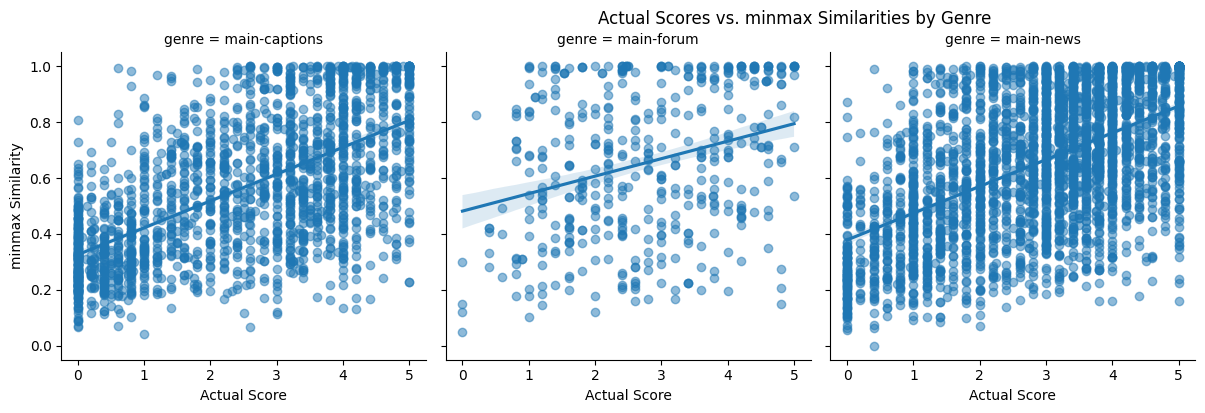

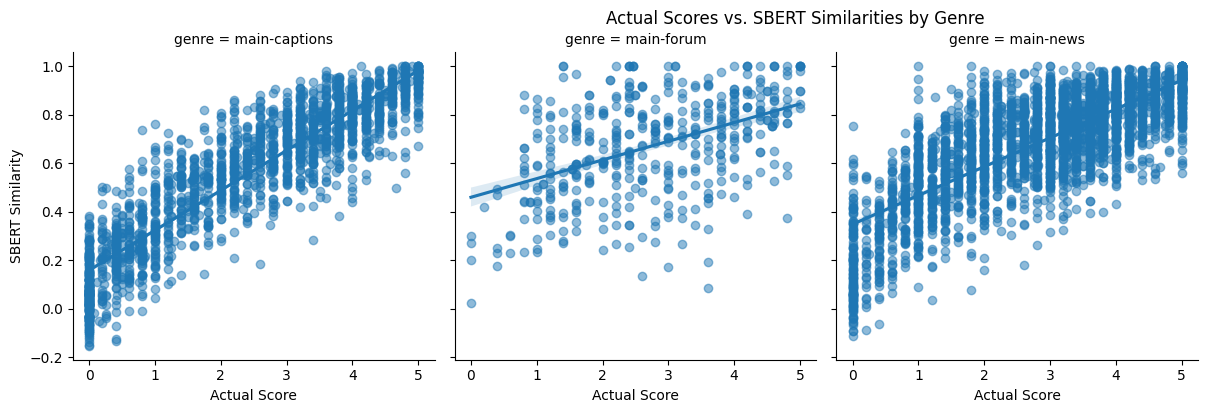

In [16]:
g = sns.FacetGrid(df_sts, col='genre', col_wrap=4, height=4)
g.map(sns.regplot, 'score', 'minmax_similarity', scatter_kws={'alpha':0.5})
g.fig.suptitle('Actual Scores vs. minmax Similarities by Genre', y=1.02)
g.set_axis_labels('Actual Score', 'minmax Similarity')
plt.show()

g = sns.FacetGrid(df_sts, col='genre', col_wrap=4, height=4)
g.map(sns.regplot, 'score', 'sbert_similarity', scatter_kws={'alpha':0.5})
g.fig.suptitle('Actual Scores vs. SBERT Similarities by Genre', y=1.02)
g.set_axis_labels('Actual Score', 'SBERT Similarity')
plt.show()


In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def analyze_errors(df_sts):
    df_sts['score_normalized'] = df_sts['score'] / 5
    df_sts['error_minmax'] = df_sts['score_normalized'] - df_sts['minmax_similarity']
    df_sts['error_sbert'] = df_sts['score_normalized'] - df_sts['sbert_similarity']

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    sns.histplot(df_sts['error_minmax'], bins=20, kde=True)
    plt.title('Error Distribution for SIF-minmax Similarities')
    plt.xlabel('Error (Normalized Score - Similarity)')
    plt.xlim(-1, 1) 

    plt.subplot(1, 2, 2)
    sns.histplot(df_sts['error_sbert'], bins=20, kde=True)
    plt.title('Error Distribution for SBERT Similarities')
    plt.xlabel('Error (Normalized Score - Similarity)')
    plt.xlim(-1, 1) 

    plt.tight_layout()
    plt.show()

def compute_statistics(df_sts):
    # Pearson Correlation
    sbert_pearson_corr = np.corrcoef(df_sts['score'], df_sts['sbert_similarity'])[0, 1]
    sif_pearson_corr = np.corrcoef(df_sts['score'], df_sts['minmax_similarity'])[0, 1]

    # Spearman Correlation
    sbert_spearman_corr, _ = stats.spearmanr(df_sts['score'], df_sts['sbert_similarity'])
    sif_spearman_corr, _ = stats.spearmanr(df_sts['score'], df_sts['minmax_similarity'])

    # Kendall's Tau
    sbert_kendall_tau, _ = stats.kendalltau(df_sts['score'], df_sts['sbert_similarity'])
    sif_kendall_tau, _ = stats.kendalltau(df_sts['score'], df_sts['minmax_similarity'])

    # Mean Absolute Error
    sbert_mae = mean_absolute_error(df_sts['score_normalized'], df_sts['sbert_similarity'])
    sif_mae = mean_absolute_error(df_sts['score_normalized'], df_sts['minmax_similarity'])

    # Mean Squared Error
    sbert_mse = mean_squared_error(df_sts['score_normalized'], df_sts['sbert_similarity'])
    sif_mse = mean_squared_error(df_sts['score_normalized'], df_sts['minmax_similarity'])

    # Root Mean Squared Error
    sbert_rmse = np.sqrt(sbert_mse)
    sif_rmse = np.sqrt(sif_mse)

    # R-squared
    sbert_r2 = r2_score(df_sts['score_normalized'], df_sts['sbert_similarity'])
    sif_r2 = r2_score(df_sts['score_normalized'], df_sts['minmax_similarity'])

    print(f'SentenceTransformer Pearson Correlation: {sbert_pearson_corr}')
    print(f'SentenceTransformer Spearman Correlation: {sbert_spearman_corr}')
    print(f'SentenceTransformer Kendall’s Tau: {sbert_kendall_tau}')
    print(f'SentenceTransformer MAE: {sbert_mae}')
    print(f'SentenceTransformer MSE: {sbert_mse}')
    print(f'SentenceTransformer RMSE: {sbert_rmse}')
    print(f'SentenceTransformer R-squared: {sbert_r2}')

    print(f'SIF Pearson Correlation: {sif_pearson_corr}')
    print(f'SIF Spearman Correlation: {sif_spearman_corr}')
    print(f'SIF Kendall’s Tau: {sif_kendall_tau}')
    print(f'SIF MAE: {sif_mae}')
    print(f'SIF MSE: {sif_mse}')
    print(f'SIF RMSE: {sif_rmse}')
    print(f'SIF R-squared: {sif_r2}')

    return {
        "sbert": {
            "pearson": sbert_pearson_corr,
            "spearman": sbert_spearman_corr,
            "kendall": sbert_kendall_tau,
            "mae": sbert_mae,
            "mse": sbert_mse,
            "rmse": sbert_rmse,
            "r2": sbert_r2,
        },
        "sif": {
            "pearson": sif_pearson_corr,
            "spearman": sif_spearman_corr,
            "kendall": sif_kendall_tau,
            "mae": sif_mae,
            "mse": sif_mse,
            "rmse": sif_rmse,
            "r2": sif_r2,
        }
    }

statistics = compute_statistics(df_sts)


SentenceTransformer Pearson Correlation: 0.8169475668582626
SentenceTransformer Spearman Correlation: 0.7852622328191703
SentenceTransformer Kendall’s Tau: 0.608619981422537
SentenceTransformer MAE: 0.15295461200601834
SentenceTransformer MSE: 0.03895772001725994
SentenceTransformer RMSE: 0.19737710104584053
SentenceTransformer R-squared: 0.5457544220249964
SIF Pearson Correlation: 0.5648092841007839
SIF Spearman Correlation: 0.5492536528287979
SIF Kendall’s Tau: 0.3911806237211977
SIF MAE: 0.21551885075285349
SIF MSE: 0.0720214203441476
SIF RMSE: 0.26836806878641056
SIF R-squared: 0.16023289616759673


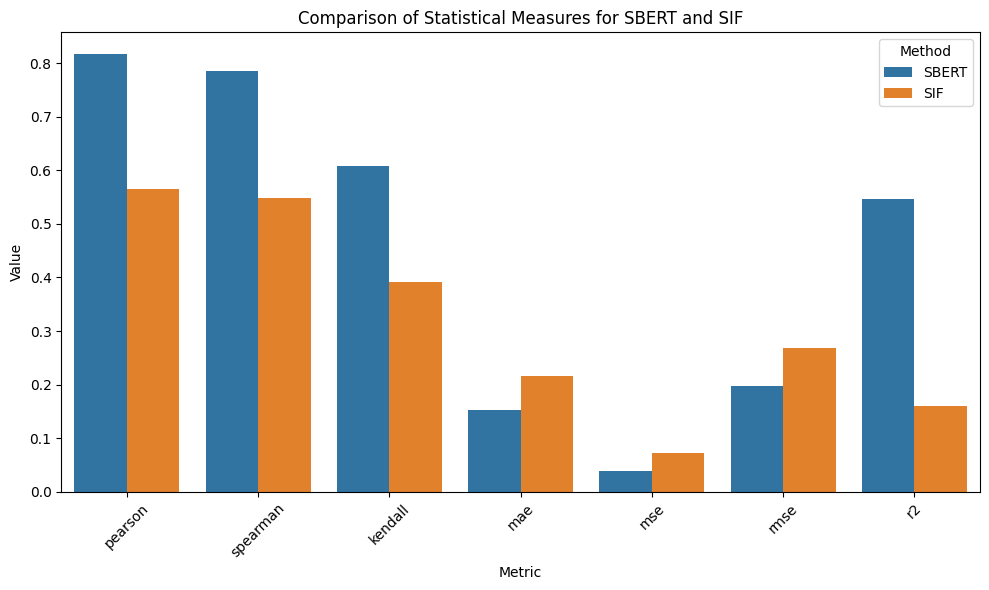

In [18]:
import pandas as pd

def visualize_statistics(statistics):
    metrics = ["pearson", "spearman", "kendall", "mae", "mse", "rmse", "r2"]
    sbert_values = [statistics["sbert"][metric] for metric in metrics]
    sif_values = [statistics["sif"][metric] for metric in metrics]

    df_stats = pd.DataFrame({
        "Metric": metrics,
        "SBERT": sbert_values,
        "SIF": sif_values
    })

    df_stats_melted = df_stats.melt(id_vars="Metric", var_name="Method", value_name="Value")

    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_stats_melted, x="Metric", y="Value", hue="Method")
    plt.title('Comparison of Statistical Measures for SBERT and SIF')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

visualize_statistics(statistics)


In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pandas as pd
import string

def preprocess_text1(text_series: pd.Series) -> pd.Series:

    if isinstance(text_series, list): # convert data to series
        text_series = pd.Series(text_series)

    text_series = text_series.lower()

    text_series = text_series.apply(word_tokenize)

    stop_words = set(stopwords.words('english'))
    punctuation = set(string.punctuation)

    text_series = text_series.apply(
        lambda tokens: [word for word in tokens if word.isalnum() and word not in stop_words]
    )
    
    return text_series

from rank_bm25 import BM25Okapi

tokenized_corpus1 = [preprocess_text1(sent) for sent in df_sts['sentence1'].tolist()]
tokenized_corpus2 = [preprocess_text1(sent) for sent in df_sts['sentence2'].tolist()]

bm25 = BM25Okapi(tokenized_corpus1 + tokenized_corpus2)

bm25_scores = []
for i in range(len(df_sts)):
    query = tokenized_corpus2[i]
    scores = bm25.get_scores(query)
    bm25_scores.append(scores[i])

NameError: name 'df_sts' is not defined